# The Source Code for Lab Exercise 3.
## Steps
1. Preprocess the Data.
2. Create a Train and Test Split
3. Create a Convolutional Neural Network using Keras.
4. Experiment on Various Elements
5. Discussion and Analysis of Experiments.

# Possible Things to Experiment on
1. Other Preprocessing methods for Images.
2. Adding Max Pooling.
3. Changing number of Filters.
4. Changing Kernel Size.
5. Changing Learning Rate.
6. Changing Optimizers.
7. TBA

### Checking the Dataset for valid Image types

In [1]:
from pathlib import Path
import imghdr
import os

DATA_DIR = "hair_types"
IMAGE_EXTENSIONS = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

/var/folders/mp/c7pgmq8j0472f05vnx5h16000000gn/T/ipykernel_78174/64068904.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Preprocessing Images and Creating Train/Test Splits using Keras util methods
#### Learn more:
```
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
```

In [2]:
# Import Tensorflow
import tensorflow as tf
#from tensorflow import keras
#from keras import layers
# Define parameters for preprocessor
BATCH_SIZE = 32
HEIGHT = 128
WIDTH = 128

### Preprocessing images from Scratch

In [3]:
# Generating a dataset using keras.util
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    labels='inferred'
)

Found 985 files belonging to 3 classes.
Using 788 files for training.
Using 197 files for validation.


2024-04-15 09:42:47.740748: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-15 09:42:47.740768: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-15 09:42:47.740774: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-15 09:42:47.740790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 09:42:47.740816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Visualizing the Initial Dataset

2024-04-15 09:42:48.608398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


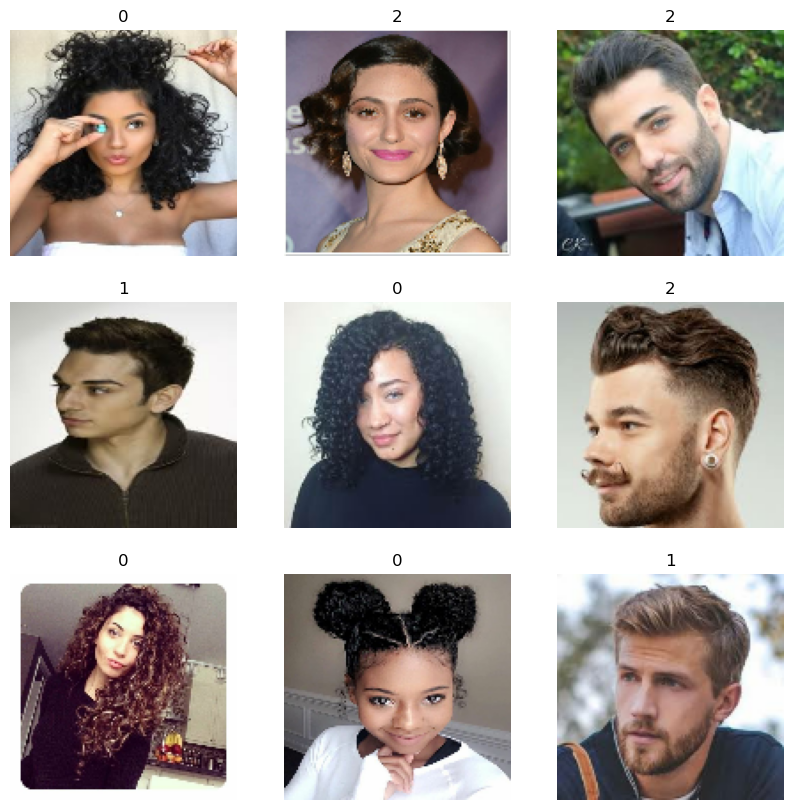

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

#### Data Augmentation
##### Since the image data is not that many, we artificially produce sample images by flipping or rotating the present images.

In [5]:
data_augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
]
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

#### Visualizing Data Augmentation

2024-04-15 09:42:49.785716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


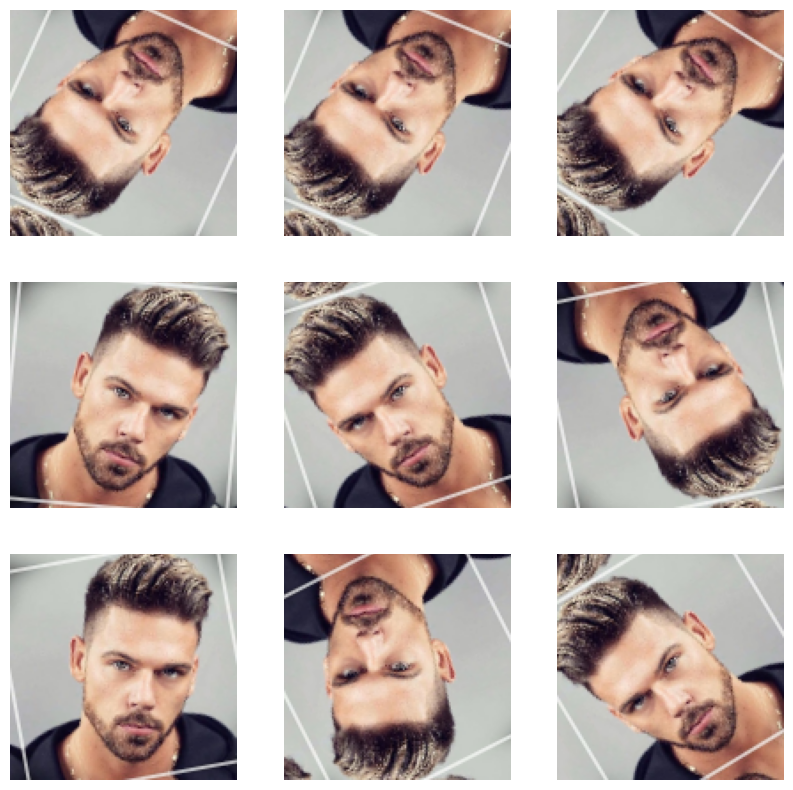

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
plt.show()

In [7]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Apply `data_augmentation` to the training images.
train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE)

### Creating the CNN Model

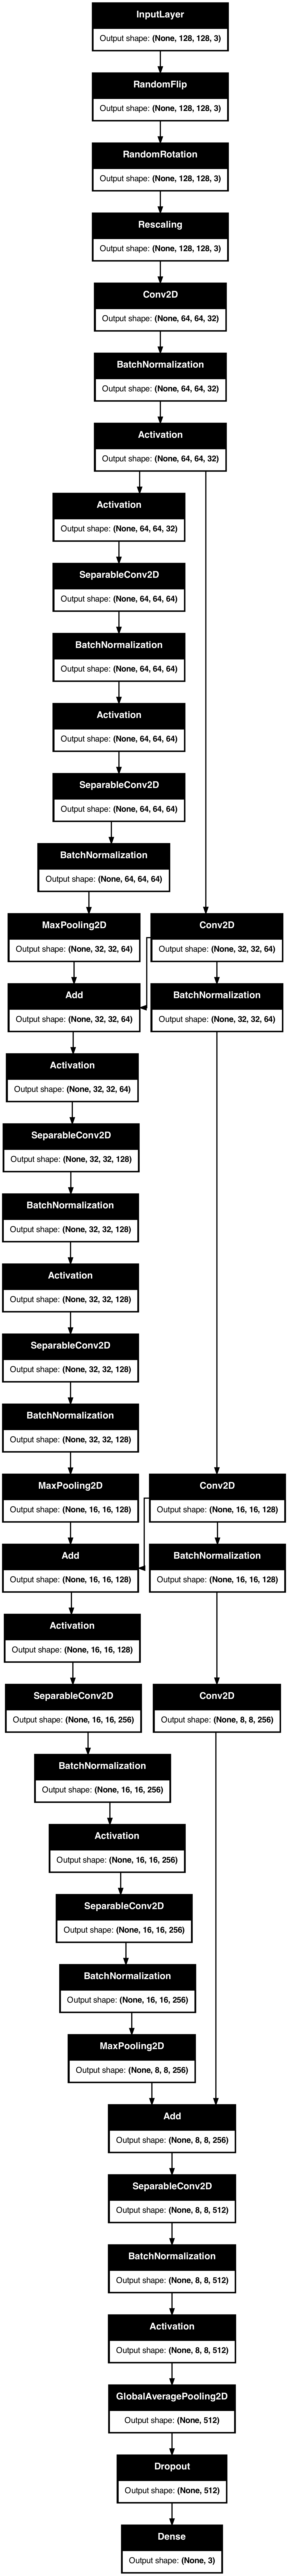

In [8]:
# 2. Adding Max Pooling.
# 3. Changing number of Filters.
# 4. Changing Kernel Size.

def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)
        
        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        previous_block_activation = tf.keras.layers.BatchNormalization()(residual)

        x = tf.keras.layers.add([x, residual])  # Add back residual

    x = tf.keras.layers.SeparableConv2D(filters=512, kernel_size=3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = make_model(input_shape=(HEIGHT, WIDTH) + (3,), num_classes=3)
tf.keras.utils.plot_model(model, to_file='test_logs//model_test.png', show_shapes=True)

### Training of the Model

In [9]:
# 5. Changing Learning Rate.
# 6. Changing Optimizers.
# OPTIMIZER = keras.optimizers.

EPOCHS = 30
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("test_logs/checkpoint/save_at_{epoch}.keras"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1, factor=0.5, min_lr=0.00001),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
)


/opt/anaconda3/envs/ML/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [10]:
cnn = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)
model.summary()

Epoch 1/30


2024-04-15 09:42:51.232755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.4103 - loss: 1.1981 - val_accuracy: 0.3604 - val_loss: 1.0976
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.5377 - loss: 0.9607 - val_accuracy: 0.2843 - val_loss: 1.1001
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.5700 - loss: 0.8983 - val_accuracy: 0.2843 - val_loss: 1.1029
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.5749 - loss: 0.8927 - val_accuracy: 0.2843 - val_loss: 1.1082
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.5873 - loss: 0.8481 - val_accuracy: 0.2843 - val_loss: 1.1110
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6213 - loss: 0.8444 - val_accuracy: 0.2843 - val_loss: 1.1308
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.5620 - loss: 0.8841 - val_accuracy: 0.2843 - val_loss: 1.1138
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.6069 - loss: 0.7999 - val_accuracy: 0.2843 - val

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 128, 128,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ random_rotation[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 64, 64,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 64, 64,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ add[0][0]       

 Total params: 641,288 (2.45 MB)

 Trainable params: 319,011 (1.22 MB)

 Non-trainable params: 3,264 (12.75 KB)

 Optimizer params: 319,013 (1.22 MB)

### Evaluation of the Model

In [11]:
img_path = "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Predict probabilities
predictions = model.predict(img_array)[0]  

# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Curly Hair", "Straight Hair", "Wavy Hair"]  
percentage_str = ", ".join(["%.2f percent %s" % (p, class_names[i]) for i, p in enumerate(scaled_predictions)])
print("This image is " + percentage_str + ".")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
This image is 99.99 percent Curly Hair, 0.00 percent Straight Hair, 0.01 percent Wavy Hair.


### Predicting a Random Image

hair_types/Wavy_Hair/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This image is 15.44 percent Curly Hair, 32.06 percent Straight Hair, 52.50 percent Wavy Hair.


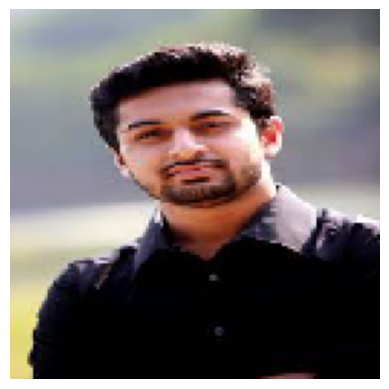

In [17]:
import os
import random
folder_number = random.randint(1, 3)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "hair_types/Curly_Hair/"
elif folder_number == 2:
    dataset_dir = "hair_types/Straight_Hair/"
else:
    dataset_dir = "hair_types/Wavy_Hair/"

print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)

image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]


# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Curly Hair", "Straight Hair", "Wavy Hair"]  
percentage_str = ", ".join(["%.2f percent %s" % (p, class_names[i]) for i, p in enumerate(scaled_predictions)])
print("This image is " + percentage_str + ".")
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization of Model with respect to Epochs

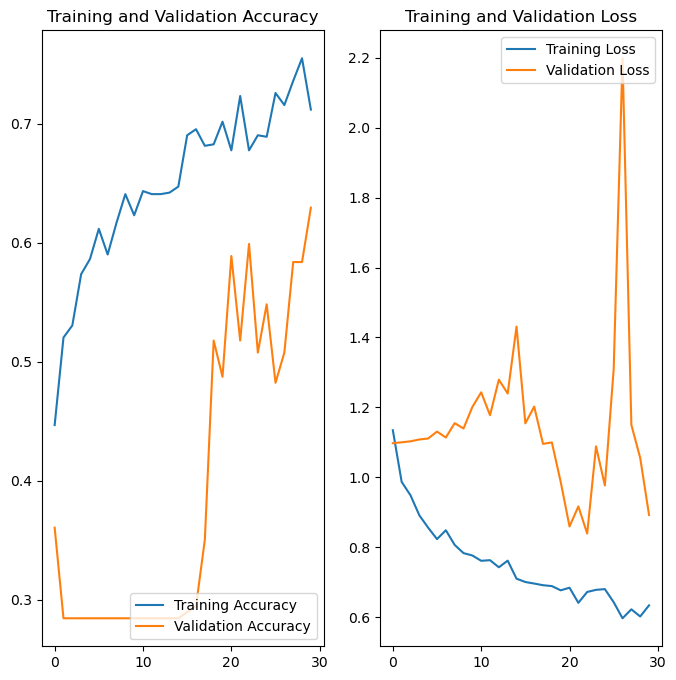

In [13]:
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']

loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()